## Kernel Density Estimation

In [1]:
%matplotlib inline
import os
import math
import random
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
np.random.seed(22)

## Method 1: Replace True Labels with Probabilities from KDE + Fitting LR
#### y = Score_Positive / (Score_positive + Score_negative)


## Method 2: Generate double points from KDE + LR fitting

### Logistic Regression Model

In [2]:
class LR:
    def __init__(self, learnRate = 0.001, nIter = 1000, use_intercept = True, smoothed = False):
        self.learnRate = learnRate
        self.nIter = nIter
        self.intercept = use_intercept
        self.smooth = smoothed
        
    def crossEntropy(self, P, Y):
        return (-Y * np.log(P) - (1 - Y + 1e-9) * np.log(1 - P + 1e-9)).mean()
    
    def sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
    
    def SGD(self, X_train, y_train, X_test, y_test, y_train_smoothed = np.zeros(1)):
        if self.smooth == False:
            y_train_smoothed = np.zeros(len(y_train))
        #Add Intercept
        if self.intercept == True:
            X_train = np.concatenate((np.ones((X_train.shape[0], 1)), X_train), axis=1)
            X_test = np.concatenate((np.ones((X_test.shape[0], 1)), X_test), axis=1)
        #Initialize Weights by zeros
        self.Ws = np.zeros(X_train.shape[1])
        oldWs = np.zeros(X_train.shape[1])
        CETEST = 1
        self.converge = self.nIter
        #Update weights for n Iterations
        flag = 0
        counter = 0
        finish = False
        for i in range(self.nIter):
            if i % 5000 == 0 and i != 0:
                print('Finished ', i, ' iterations --> Test CE:', CETEST)
            #Shuffle indeces
            p = np.random.permutation(len(X_train))
            X_train = X_train[p]
            y_train = y_train[p]
            y_train_smoothed = y_train_smoothed[p]
            for row,y_t, y_t_s in zip(X_train, y_train, y_train_smoothed):
                Z = np.dot(row, self.Ws)
                y_p = self.sigmoid(Z)
                if self.smooth:
                    gradient = np.dot(row.T, (y_p - y_t_s))
                else:
                    gradient = np.dot(row.T, (y_p - y_t))
                self.Ws -= self.learnRate * gradient
                # Check convergence
                diff = np.max(np.absolute(oldWs - self.Ws))
                if diff <= 1e-4 and flag > 500:
                    self.converge = counter
                    finish = True
                    break
                elif diff <= 1e-4 and flag <= 500:
                    flag += 1
                else:
                    flag = 0
                    oldWs = self.Ws
                    
                counter += 1
            
            if finish:
                break
    
    def predict_prob(self, X):
        #Add Intercept
        if self.intercept == True:
            intercept = np.ones((X.shape[0], 1))
            X = np.concatenate((intercept, X), axis=1)
        return self.sigmoid(np.dot(X, self.Ws))
    
    def predict(self, X, threshold = 0.5):
        return self.predict_prob(X) >= threshold

# Evaluation Experiments

In [3]:
files = []
dataset_names = []
# r=root, d=directories, f = files
for r, d, f in os.walk('Datasets\\'):
    for file in f:
        if '.csv' in file:
            dataset_names.append(file)
            files.append(os.path.join(r, file))

In [4]:
res = {'Name':[], 'Instances':[], 'Features':[], 'PosClassRatio':[], 
        'NTestCE':[], 'M1TestCE':[], 'M2TestCE':[], 'PTestCE':[], 'SKTestCE':[], 
        'NTrainCE':[], 'M1TrainCE':[], 'M2TrainCE':[], 'PTrainCE':[], 'SKTrainCE':[], 
        'NTestAcc':[], 'M1TestAcc':[], 'M2TestAcc':[], 'PTestAcc':[], 'SKTestAcc':[],
        'NTrainAcc':[], 'M1TrainAcc':[], 'M2TrainAcc':[], 'PTrainAcc':[], 'SKTrainAcc':[],
       'NConverge':[], 'M1Converge':[], 'M2Converge':[], 'PConverge':[], 'SKConverge':[]
      }
results = pd.DataFrame(res)

### Define Hyper-parameters

In [5]:
LRate = 1e-5
nIter = 50000

### Data statistics

In [6]:
def meta_features(data):
    n_rows = len(data)
    n_feats = len(data.columns) - 1
    pos_class_ratio = (data['class'] == 1).sum() / n_rows
    return n_rows, n_feats, pos_class_ratio

### Normal LR Results

In [7]:
def normal_results(X_train, y_train, X_test, y_test):
    model = LR(learnRate = LRate, nIter = nIter)
    model.SGD(X_train.values, y_train.values, X_test.values, y_test.values)
    
    y_pred_test  = model.predict_prob(X_test)
    y_pred_train = model.predict_prob(X_train)
    
    CE_test  = model.crossEntropy(y_pred_test,  y_test)
    CE_train = model.crossEntropy(y_pred_train, y_train)
    
    y_pred_test_labels  = model.predict(X_test)
    y_pred_train_labels = model.predict(X_train)
    
    acc_test  = accuracy_score(y_test,  y_pred_test_labels ) * 100
    acc_train = accuracy_score(y_train, y_pred_train_labels) * 100
    
    return acc_test, CE_test, acc_train, CE_train, model.converge, model

### Platt Logistic Regression

In [8]:
def platt_results(X_train, y_train, X_test, y_test):
    #smoothed Labels
    NP = (y_train > 0.5).sum()
    NN = len(y_train) - NP
    y_train_smoothed = np.zeros(len(y_train))
    y_tmp = y_train.values
    for i in range(len(y_train)):
        if y_tmp[i] > 0:
            y_train_smoothed[i] = 1 - 1 / (NP + 2)
        else:
            y_train_smoothed[i] = 1 / (NN + 2)
        
    model = LR(learnRate = LRate, nIter = nIter, smoothed = True)
    model.SGD(X_train.values, y_train.values, X_test.values, y_test.values, y_train_smoothed)
    
    y_pred_test  = model.predict_prob(X_test)
    y_pred_train = model.predict_prob(X_train)
    
    CE_test  = model.crossEntropy(y_pred_test,  y_test)
    CE_train = model.crossEntropy(y_pred_train, y_train)
    
    y_pred_test_labels  = model.predict(X_test)
    y_pred_train_labels = model.predict(X_train)
    
    acc_test  = accuracy_score(y_test,  y_pred_test_labels ) * 100
    acc_train = accuracy_score(y_train, y_pred_train_labels) * 100
    
    return acc_test, CE_test, acc_train, CE_train, model.converge

### Sklearn Results

In [9]:
def sklearn_results(X_train, y_train, X_test, y_test, model):
    model_sklearn = LogisticRegression(random_state=22, solver='lbfgs').fit(X_train, y_train)
    y_pred_test  = model_sklearn.predict_proba(X_test)
    y_pred_train = model_sklearn.predict_proba(X_train)
    
    CE_test  = model.crossEntropy(y_pred_test[:,1] , y_test)
    CE_train = model.crossEntropy(y_pred_train[:,1], y_train)
    
    y_pred_test_labels  = model_sklearn.predict(X_test)
    y_pred_train_labels = model_sklearn.predict(X_train)
    
    acc_test  = accuracy_score(y_test,  y_pred_test_labels ) * 100
    acc_train = accuracy_score(y_train, y_pred_train_labels) * 100
    
    return acc_test, CE_test, acc_train, CE_train

### Create Kernels of positive and negative classes

In [10]:
def kernels(X_train, y_train):
    #split training set into positive and negative instances (S1, S0)
    poss = []
    negs = []
    y_tmp = y_train.values
    for i in range(len(y_train)):
        if y_tmp[i] == 0:
            negs.append(i)
        else:
            poss.append(i)
    S0 = (X_train.iloc[negs,:]).T.values
    S1 = (X_train.iloc[poss,:]).T.values
    #Create positive and negative classes kernels
    neg_kernel = stats.gaussian_kde(S0)
    pos_kernel = stats.gaussian_kde(S1)
    
    #Calculate smoothed labels based on values from the kernels
    P_S0 = pos_kernel.evaluate(S0) / (pos_kernel.evaluate(S0) + neg_kernel.evaluate(S0))
    P_S1 = pos_kernel.evaluate(S1) / (pos_kernel.evaluate(S1) + neg_kernel.evaluate(S1))
    y_train_prob = np.zeros(len(y_train))
    neg_index = 0
    pos_index = 0
    for i in range(len(y_train)):
        if y_tmp[i] == 0:
            y_train_prob[i] = P_S0[neg_index]
            neg_index += 1
        else:
            y_train_prob[i] = P_S1[pos_index]
            pos_index += 1
            
    return pos_kernel, neg_kernel, y_train_prob

### Method 1

In [11]:
def M1_results(X_train, y_train, X_test, y_test, y_train_prob):
    #Train the LR model with the smoothed labels
    model = LR(learnRate = LRate, nIter = nIter, smoothed = True)
    model.SGD(X_train.values, y_train.values, X_test.values, y_test.values, y_train_prob)
    
    y_pred_test  = model.predict_prob(X_test)
    y_pred_train = model.predict_prob(X_train)
    
    CE_test  = model.crossEntropy(y_pred_test,  y_test)
    CE_train = model.crossEntropy(y_pred_train, y_train)
    
    y_pred_test_labels  = model.predict(X_test)
    y_pred_train_labels = model.predict(X_train)
    
    acc_test  = accuracy_score(y_test,  y_pred_test_labels ) * 100
    acc_train = accuracy_score(y_train, y_pred_train_labels) * 100
    
    return acc_test, CE_test, acc_train, CE_train, model.converge

### Method 2

In [12]:
def M2_results(X_train, y_train, X_test, y_test, pos_kernel, neg_kernel):
    N0_2 = int((y_train == 0).sum() * 2)
    N1_2 = int((y_train == 1).sum() * 2)
    neg2 = neg_kernel.resample(N0_2)
    pos2 = pos_kernel.resample(N1_2)

    X_train2 = np.array(np.concatenate((neg2.T, pos2.T), axis=0) )
    y_train2 = np.asarray([0] * N0_2 + [1] * N1_2)
    
    #Train the LR model with Method2
    model = LR(learnRate = LRate, nIter = nIter)
    model.SGD(X_train2, y_train2, X_test, y_test)
    
    y_pred_test  = model.predict_prob(X_test)
    y_pred_train = model.predict_prob(X_train)
    
    CE_test  = model.crossEntropy(y_pred_test,  y_test)
    CE_train = model.crossEntropy(y_pred_train, y_train)
    
    y_pred_test_labels  = model.predict(X_test)
    y_pred_train_labels = model.predict(X_train)
    
    acc_test  = accuracy_score(y_test,  y_pred_test_labels ) * 100
    acc_train = accuracy_score(y_train, y_pred_train_labels) * 100
    
    return acc_test, CE_test, acc_train, CE_train, model.converge

### Collect Results

In [13]:
rs = [1, 23, 24, 72, 404, 801, 77, 31, 0, 10]
for f in files:
    # Read Dataset
    print('Dataset Name:', f)
    data = pd.read_csv(f)
    rows, cols, ratio = meta_features(data)
    res = {'Name':f, 'Instances':rows, 'Features':cols, 'PosClassRatio':ratio,
           'NTestCE':0, 'M1TestCE':0, 'M2TestCE':0, 'PTestCE':0, 'SKTestCE':0, 
           'NTrainCE':0, 'M1TrainCE':0, 'M2TrainCE':0, 'PTrainCE':0, 'SKTrainCE':0, 
           'NTestAcc':0, 'M1TestAcc':0, 'M2TestAcc':0, 'PTestAcc':0, 'SKTestAcc':0,
           'NTrainAcc':0, 'M1TrainAcc':0, 'M2TrainAcc':0, 'PTrainAcc':0, 'SKTrainAcc':0,
           'NConverge':0, 'M1Converge':0, 'M2Converge':0, 'PConverge':0, 'SKConverge':0}
    for r in rs:
        X_train, X_test, y_train, y_test = train_test_split(data.drop('class', axis=1), data['class'], 
                                                            test_size=0.3, random_state=r)
        X_train = (X_train - X_train.mean()) / X_train.std()
        X_test = (X_test - X_train.mean()) / X_train.std()

        #Normal LR
        print('Start Normal:')
        ac1, ce1, ac2, ce2, converge, model = normal_results(X_train, y_train, X_test, y_test)
        res['NTestCE'] += ce1; res['NTestAcc'] += ac1; res['NTrainCE'] += ce2; res['NTrainAcc'] += ac2; 
        res['NConverge'] += converge

        #Platt LR
        print('Start Platt:')
        ac1, ce1, ac2, ce2, converge = platt_results(X_train, y_train, X_test, y_test)
        res['PTestCE'] += ce1; res['PTestAcc'] += ac1; res['PTrainCE'] += ce2; res['PTrainAcc'] += ac2; 
        res['PConverge'] += converge

        #Sklearn Results
        print('Start SKLearn:')
        ac1, ce1, ac2, ce2 = sklearn_results(X_train, y_train, X_test, y_test, model)
        res['SKTestCE'] += ce1; res['SKTestAcc'] += ac1; res['SKTrainCE'] += ce2; res['SKTrainAcc'] += ac2;
        res['SKConverge'] += 0
        
        #KDE Kernels
        pos_kernel, neg_kernel, y_train_prob = kernels(X_train, y_train)
        #Method 1
        print('Start Method1:')
        ac1, ce1, ac2, ce2, converge = M1_results(X_train, y_train, X_test, y_test, y_train_prob)
        res['M1TestCE'] += ce1; res['M1TestAcc'] += ac1; res['M1TrainCE'] += ce2; res['M1TrainAcc'] += ac2; 
        res['M1Converge'] += converge
        #Method 2
        print('Start Method2:')
        ac1, ce1, ac2, ce2, converge = M2_results(X_train, y_train, X_test, y_test, pos_kernel, neg_kernel)
        res['M2TestCE'] += ce1; res['M2TestAcc'] += ac1; res['M2TrainCE'] += ce2; res['M2TrainAcc'] += ac2; 
        res['M2Converge'] += converge
    
    for ke in res.keys():
        if ke not in ['PosClassRatio', 'Name', 'Features', 'Instances']:
            res[ke] /= len(rs)
    results = results.append(res, ignore_index=True)
    print(res, '\n########################################\n')

Dataset Name: Datasets\aecoli.csv
Start Normal:
Start Platt:
Start SKLearn:
Start Method1:
Start Method2:
Start Normal:
Start Platt:
Start SKLearn:
Start Method1:
Start Method2:
Start Normal:
Start Platt:
Start SKLearn:
Start Method1:
Start Method2:
Start Normal:
Start Platt:
Start SKLearn:
Start Method1:
Start Method2:
Start Normal:
Start Platt:
Start SKLearn:
Start Method1:
Start Method2:
Start Normal:
Start Platt:
Start SKLearn:
Start Method1:
Start Method2:
Start Normal:
Start Platt:
Start SKLearn:
Start Method1:
Start Method2:
Start Normal:
Start Platt:
Start SKLearn:
Start Method1:
Start Method2:
Start Normal:
Start Platt:
Start SKLearn:
Start Method1:
Start Method2:
Start Normal:
Start Platt:
Start SKLearn:
Start Method1:
Start Method2:
{'Name': 'Datasets\\aecoli.csv', 'Instances': 336, 'Features': 5, 'PosClassRatio': 0.4255952380952381, 'NTestCE': 0.6925648276517967, 'M1TestCE': 0.692569732380648, 'M2TestCE': 0.6925693808836467, 'PTestCE': 0.6925767984021556, 'SKTestCE': 1.3214

Start Method1:
Start Method2:
Start Normal:
Start Platt:
Start SKLearn:
Start Method1:
Start Method2:
Start Normal:
Start Platt:
Start SKLearn:
Start Method1:
Start Method2:
Start Normal:
Start Platt:
Start SKLearn:
Start Method1:
Start Method2:
Start Normal:
Start Platt:
Start SKLearn:
Start Method1:
Start Method2:
Start Normal:
Start Platt:
Start SKLearn:
Start Method1:
Start Method2:
Start Normal:
Start Platt:
Start SKLearn:
Start Method1:
Start Method2:
Start Normal:
Start Platt:
Start SKLearn:
Start Method1:
Start Method2:
Start Normal:
Start Platt:
Start SKLearn:
Start Method1:
Start Method2:
Start Normal:
Start Platt:
Start SKLearn:
Start Method1:
Start Method2:
{'Name': 'Datasets\\dataset_37_diabetes.csv', 'Instances': 768, 'Features': 8, 'PosClassRatio': 0.3489583333333333, 'NTestCE': 0.7230969960531802, 'M1TestCE': 0.7216658051521843, 'M2TestCE': 0.722930741859036, 'PTestCE': 0.7228371092933774, 'SKTestCE': 13.282548001005068, 'NTrainCE': 0.6924318244229661, 'M1TrainCE': 0.69

C:\Users\s-moh\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
C:\Users\s-moh\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


Start Method1:
Start Method2:
Start Normal:
Start Platt:
Start SKLearn:
Start Method1:
Start Method2:
Start Normal:
Start Platt:
Start SKLearn:


C:\Users\s-moh\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
C:\Users\s-moh\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


Start Method1:
Start Method2:
Start Normal:
Start Platt:
Start SKLearn:
Start Method1:
Start Method2:
Start Normal:
Start Platt:
Start SKLearn:
Start Method1:
Start Method2:
Start Normal:
Start Platt:
Start SKLearn:


C:\Users\s-moh\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
C:\Users\s-moh\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


Start Method1:
Start Method2:
Start Normal:
Start Platt:
Start SKLearn:


C:\Users\s-moh\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
C:\Users\s-moh\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


Start Method1:
Start Method2:
Start Normal:
Start Platt:
Start SKLearn:


C:\Users\s-moh\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
C:\Users\s-moh\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


Start Method1:
Start Method2:
Start Normal:
Start Platt:
Start SKLearn:


C:\Users\s-moh\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
C:\Users\s-moh\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


Start Method1:
Start Method2:
Start Normal:
Start Platt:
Start SKLearn:
Start Method1:
Start Method2:
{'Name': 'Datasets\\eegeyestate.csv', 'Instances': 14980, 'Features': 14, 'PosClassRatio': 0.4487983978638184, 'NTestCE': 4.009351823901014, 'M1TestCE': 1.9448770876795638, 'M2TestCE': 1.6328804450585832, 'PTestCE': 1.7852658310547214, 'SKTestCE': inf, 'NTrainCE': 0.6930905493036799, 'M1TrainCE': 0.6931715645879754, 'M2TrainCE': 0.6931021686848254, 'PTrainCE': 0.6930944724533838, 'SKTrainCE': 0.6494755465851197, 'NTestAcc': 45.82109479305742, 'M1TestAcc': 51.01913662661326, 'M2TestAcc': 47.85491766800178, 'PTestAcc': 48.072986203827334, 'SKTestAcc': 46.90698709390298, 'NTrainAcc': 57.483311081441926, 'M1TrainAcc': 49.028228113675375, 'M2TrainAcc': 56.96738508487507, 'PTrainAcc': 57.318329200839216, 'SKTrainAcc': 61.19015830631319, 'NConverge': 649.2, 'M1Converge': 566.5, 'M2Converge': 616.1, 'PConverge': 637.4, 'SKConverge': 0.0} 
########################################

Dataset Name:

C:\Users\s-moh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\s-moh\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
C:\Users\s-moh\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


Start Method1:
Start Method2:
Start Normal:
Start Platt:
Start SKLearn:


C:\Users\s-moh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\s-moh\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
C:\Users\s-moh\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


Start Method1:
Start Method2:
Start Normal:
Start Platt:
Start SKLearn:


C:\Users\s-moh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\s-moh\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
C:\Users\s-moh\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


Start Method1:
Start Method2:
Start Normal:
Start Platt:
Start SKLearn:


C:\Users\s-moh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\s-moh\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
C:\Users\s-moh\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


Start Method1:
Start Method2:
Start Normal:
Start Platt:
Start SKLearn:


C:\Users\s-moh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\s-moh\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
C:\Users\s-moh\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


Start Method1:
Start Method2:
Start Normal:
Start Platt:
Start SKLearn:


C:\Users\s-moh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\s-moh\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
C:\Users\s-moh\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


Start Method1:
Start Method2:
Start Normal:
Start Platt:
Start SKLearn:


C:\Users\s-moh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\s-moh\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
C:\Users\s-moh\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


Start Method1:
Start Method2:
Start Normal:
Start Platt:
Start SKLearn:


C:\Users\s-moh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\s-moh\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
C:\Users\s-moh\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


Start Method1:
Start Method2:
Start Normal:
Start Platt:
Start SKLearn:


C:\Users\s-moh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\s-moh\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
C:\Users\s-moh\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


Start Method1:
Start Method2:
Start Normal:
Start Platt:
Start SKLearn:


C:\Users\s-moh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\s-moh\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
C:\Users\s-moh\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


Start Method1:
Start Method2:
{'Name': 'Datasets\\musk.csv', 'Instances': 6598, 'Features': 166, 'PosClassRatio': 0.1541376174598363, 'NTestCE': 1.0146779821743155, 'M1TestCE': 1.1259338838572763, 'M2TestCE': 1.1918545411115762, 'PTestCE': 1.0401837696262926, 'SKTestCE': 6.609107531414134, 'NTrainCE': 0.6908929823606955, 'M1TrainCE': 0.6908034960221405, 'M2TrainCE': 0.6908257486701305, 'PTrainCE': 0.690899589116746, 'SKTrainCE': 0.11937879235921497, 'NTestAcc': 43.64646464646465, 'M1TestAcc': 42.696969696969695, 'M2TestAcc': 39.88383838383838, 'PTestAcc': 43.69191919191918, 'SKTestAcc': 74.03030303030303, 'NTrainAcc': 68.03161541792983, 'M1TrainAcc': 64.3005630142919, 'M2TrainAcc': 63.471199653529666, 'PTrainAcc': 64.21611087050671, 'SKTrainAcc': 95.60632308358598, 'NConverge': 530.1, 'M1Converge': 529.7, 'M2Converge': 524.9, 'PConverge': 529.3, 'SKConverge': 0.0} 
########################################

Dataset Name: Datasets\phoneme.csv
Start Normal:
Start Platt:
Start SKLearn:
Sta

Start Method1:
Start Method2:
{'Name': 'Datasets\\stock.csv', 'Instances': 950, 'Features': 9, 'PosClassRatio': 0.5136842105263157, 'NTestCE': 0.6837231820954282, 'M1TestCE': 0.6835002592197367, 'M2TestCE': 0.6836388507158546, 'PTestCE': 0.6835792530025193, 'SKTestCE': 80.68577820622075, 'NTrainCE': 0.6917682391834427, 'M1TrainCE': 0.6917947166163684, 'M2TrainCE': 0.691817448802569, 'PTrainCE': 0.6917758695234322, 'SKTrainCE': 0.3187063208876369, 'NTestAcc': 68.0, 'M1TestAcc': 67.50877192982455, 'M2TestAcc': 69.64912280701755, 'PTestAcc': 68.21052631578945, 'SKTestAcc': 47.29824561403508, 'NTrainAcc': 70.04511278195488, 'M1TrainAcc': 69.59398496240601, 'M2TrainAcc': 69.78947368421052, 'PTrainAcc': 69.90977443609025, 'SKTrainAcc': 84.94736842105263, 'NConverge': 536.1, 'M1Converge': 535.4, 'M2Converge': 533.7, 'PConverge': 535.5, 'SKConverge': 0.0} 
########################################

Dataset Name: Datasets\titanic.csv
Start Normal:
Start Platt:
Start SKLearn:
Start Method1:
Start

In [14]:
results.head()

,Name,Instances,Features,PosClassRatio,NTestCE,M1TestCE,M2TestCE,PTestCE,SKTestCE,NTrainCE,...,NTrainAcc,M1TrainAcc,M2TrainAcc,PTrainAcc,SKTrainAcc,NConverge,M1Converge,M2Converge,PConverge,SKConverge
0,Datasets\aecoli.csv,336.0,5.0,0.425595,0.692565,0.692570,0.692569,0.692577,1.321416,0.691259,...,93.872340,93.574468,93.872340,93.914894,96.170213,528.3,527.5,525.4,527.2,0.0
1,Datasets\balloon.csv,2001.0,1.0,0.240880,0.692134,0.692265,0.692096,0.692115,1.355635,0.692508,...,82.064286,79.071429,82.200000,82.600000,83.292857,536.4,540.2,538.7,533.8,0.0
2,Datasets\banana.csv,5300.0,2.0,0.448302,0.693115,0.693122,0.693119,0.693119,0.685201,0.693115,...,53.140162,51.382749,53.978437,52.735849,56.097035,618.9,677.9,610.4,617.5,0.0
3,Datasets\chscase_vine2.csv,468.0,2.0,0.547009,0.694175,0.693264,0.691538,0.698093,32.612924,0.693122,...,53.914373,53.730887,53.516820,54.250765,54.159021,677.1,720.5,627.4,635.0,0.0
4,Datasets\cleve.csv,303.0,13.0,0.455446,0.684315,0.684571,0.686106,0.684650,9.029883,0.691590,...,80.518868,80.707547,80.330189,80.377358,83.207547,535.4,535.9,531.2,536.9,0.0


#### Compute difference between train and test CE

In [15]:
results['N_CE_diff']  = results['NTestCE'] - results['NTrainCE']
results['M1_CE_diff'] = results['M1TestCE'] - results['M1TrainCE']
results['M2_CE_diff'] = results['M2TestCE'] - results['M2TrainCE']
results['P_CE_diff']  = results['PTestCE'] - results['PTrainCE']
results['SK_CE_diff'] = results['SKTestCE'] - results['SKTrainCE']

In [16]:
results.to_csv('Evaluation.csv', index=False)

# Results Visualization

In [17]:
test_CE_cols = ['NTestCE', 'M1TestCE', 'M2TestCE', 'PTestCE', 'SKTestCE']
test_acc_cols = ['NTestAcc', 'M1TestAcc', 'M2TestAcc', 'PTestAcc', 'SKTestAcc']
ce_diff_cols = ['N_CE_diff', 'M1_CE_diff', 'M2_CE_diff', 'P_CE_diff', 'SK_CE_diff']
converge_cols = ['NConverge', 'M1Converge', 'M2Converge', 'PConverge', 'SKConverge']
names = ['Normal LR', 'Method1', 'Method2', 'Platt LR', 'SKlearn LR']
colors_main = ['r', 'b', 'c', 'y', 'g']

In [18]:
def avgRank(data, cols, rev = False):
    #replace missing values by inf
    data.fillna(1e9, inplace=True)
    ranks = np.zeros(shape = (20, len(cols)))
    for index, row in data.iterrows():
        perfs = [] #performance of each tool
        for c in cols:
            perfs.append(row[c])
        perfs_sorted = sorted(np.unique(perfs), reverse = rev) #sorted performance
                      
        for p in range(len(perfs)):
            for i in range(len(perfs_sorted)):
                if perfs[p] == perfs_sorted[i]:
                    ranks[index, p] = i + 1
                    break
    
    #convert to dataframe
    return pd.DataFrame(data=ranks, columns=cols)

In [19]:
avgRank_CE  = avgRank(results, test_CE_cols)
avgRank_acc = avgRank(results, test_acc_cols, rev = True)
avgRank_diff = avgRank(results, ce_diff_cols)
avgConv = avgRank(results, converge_cols)
avgRankAll = np.concatenate((avgRank_CE.values.flatten('F')[:,np.newaxis], avgRank_acc.values.flatten('F')[:,np.newaxis],
                             avgRank_diff.values.flatten('F')[:,np.newaxis], avgConv.values.flatten('F')[:,np.newaxis]), 
                             axis=1)

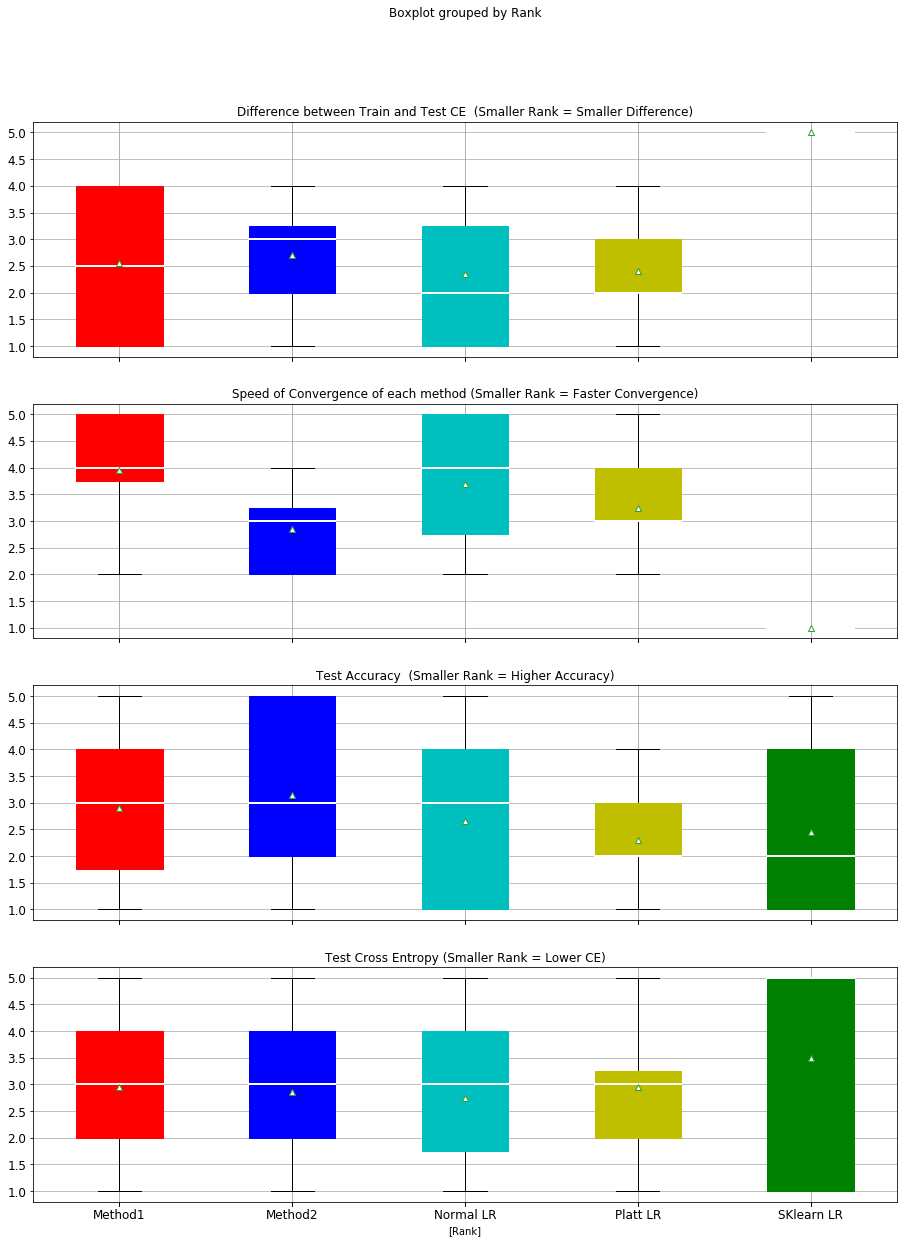

<Figure size 1440x720 with 0 Axes>

In [20]:
df = pd.DataFrame(avgRankAll, columns=['Test Cross Entropy (Smaller Rank = Lower CE)', 
                                       'Test Accuracy  (Smaller Rank = Higher Accuracy)', 
                                       'Difference between Train and Test CE  (Smaller Rank = Smaller Difference)',
                                       'Speed of Convergence of each method (Smaller Rank = Faster Convergence)'])

df['Rank'] = pd.Series(np.repeat(names, 20))


bp = df.boxplot(by="Rank", layout=(4,1), figsize=(15,20), grid = True, showmeans = True, notch = False, patch_artist=True,\
                fontsize = 12, return_type='dict')

# boxplot style adjustments
[[item.set_linewidth(2) for item in bp[key]['medians']] for key in bp.keys()]
counter = 0
for key in bp.keys():
    for item in bp[key]['boxes']:
        item.set_color(colors_main[counter % 5])
        counter += 1
[[item.set_color('w') for item in bp[key]['medians']] for key in bp.keys()]
[[item.set_markerfacecolor('w') for item in bp[key]['means']] for key in bp.keys()]
[[item.set_color('k') for item in bp[key]['whiskers']] for key in bp.keys()]

fig = plt.figure(figsize=(20, 10))
fig.suptitle('Avg Ranking for different Methods', fontsize = 12)
plt.savefig('AvgRank_Main.png')
plt.show()